In [1]:
# Binario con imágenes de 224x224 en escala de grises (por ahora el mejor modelo) utilizando flow_from_dataframe

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install unrar

In [3]:
import os
os.makedirs('data', exist_ok=True)

In [ ]:
# En tu Drive de Google tenés que crear la siguiente estructura de carpetas /IADesafio02/data/comprimidos/ y subir el rar que podés descargar desde:
# https://drive.google.com/file/d/1O4zx6xWc0QUXeASqC_IUradsKHngOUY7/view?usp=sharing

In [4]:
!unrar x '/content/drive/My Drive/IADesafio02/data/comprimidos/images_binario_224_bn.rar' './data'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Extracting  ./data/images_binario_224_bn/40619_right.jpeg                 72%  OK 
Extracting  ./data/images_binario_224_bn/40622_left.jpeg                  72%  OK 
Extracting  ./data/images_binario_224_bn/40622_right.jpeg                 72%  OK 
Extracting  ./data/images_binario_224_bn/40624_left.jpeg                  72%  OK 
Extracting  ./data/images_binario_224_bn/40624_right.jpeg                 72%  OK 
Extracting  ./data/images_binario_224_bn/40630_left.jpeg                  72%  OK 
Extracting  ./data/images_binario_224_bn/40630_right.jpeg                 72%  OK 
Extracting  ./data/images_binario_224_bn/40631_left.jpeg                  72%  OK 
Extracting  ./data/images_binario_224_bn/40631_right.jpeg                 72%  OK 
Extracting  ./data/images_binario_224_bn/40638_left.jpeg                  72%  OK 
Extracting  .

In [ ]:
# En tu Drive de Google tenés que crear la siguiente estructura de carpetas /IADesafio02/data y subir el siguiente CSV: 
# https://drive.google.com/file/d/1KLGEbVkNMAX4l_05c_6FwYEGN5_TlOgr/view?usp=sharing

In [5]:
data_dir = './data/images_binario_224_bn'
drive_dir = '/content/drive/My Drive/IADesafio02/data'

In [6]:
res_x = 224
res_y = 224

In [7]:
import os, shutil
import pandas as pd

In [8]:
df = pd.read_csv(drive_dir + '/images_binario_224.csv')

In [9]:
df['image'] = df['image'] + '.jpeg'

In [10]:
df['image'].head()

0        10_left.jpeg
1       10_right.jpeg
2     10003_left.jpeg
3    10003_right.jpeg
4     10013_left.jpeg
Name: image, dtype: object

In [11]:
df.shape

(18632, 6)

In [12]:
(X, y) = (df['image'], df['Diabetes'])
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, stratify=y, test_size=0.2, random_state=42)

In [13]:
test, val = train_test_split(train, stratify=train['Diabetes'], test_size=0.5, random_state=42)

In [14]:
train['Diabetes'].value_counts()

Si    7453
No    7452
Name: Diabetes, dtype: int64

In [15]:
test['Diabetes'].value_counts()

No    3726
Si    3726
Name: Diabetes, dtype: int64

In [16]:
val['Diabetes'].value_counts()

Si    3727
No    3726
Name: Diabetes, dtype: int64

In [17]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [18]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(res_x, res_y, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train, # Referimos el df de train
    directory=data_dir, # El directorio donde se encuentran las imágenes
    x_col='image', # La columna con los path de los archivos
    y_col='Diabetes', # La variable con las labels
    target_size=(res_x, res_y),
    classes=None, # Las clases se obtienen a partir de y_col
    class_mode='binary', # Se trata de un problema multi-class, multi-label
    batch_size=200
   )

validation_generator = val_datagen.flow_from_dataframe(
    val, # Referimos el df de validación
    directory=data_dir, # El directorio donde se encuentran las imágenes
    x_col='image', # La columna con los path de los archivos
    y_col='Diabetes', # La variable con las labels
    target_size=(res_x, res_y),
    classes=None, # Las clases se obtienen a partir de y_col
    class_mode='binary', # Se trata de un problema multi-class, multi-label
    batch_size=200,
    shuffle=False
   )

Found 14905 validated image filenames belonging to 2 classes.
Found 7453 validated image filenames belonging to 2 classes.


In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adagrad(
                learning_rate=0.001,
                initial_accumulator_value=0.1,
                epsilon=1e-07),
              metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# No se utilizan pero se dejan instanciados por si se quieren utilizar en alguna prueba
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

callbacks_list = [early_stopping, reduce_lr]

In [22]:
history = model.fit(
      train_generator,
      steps_per_epoch=30,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=1)

Epoch 1/10
30/30 [==============================] - 502s 17s/step - loss: 0.6880 - accuracy: 0.5785 - val_loss: 0.6821 - val_accuracy: 0.6210
Epoch 2/10
30/30 [==============================] - 503s 17s/step - loss: 0.6776 - accuracy: 0.6350 - val_loss: 0.6739 - val_accuracy: 0.6180
Epoch 3/10
30/30 [==============================] - 501s 17s/step - loss: 0.6702 - accuracy: 0.6295 - val_loss: 0.6666 - val_accuracy: 0.6210
Epoch 4/10
30/30 [==============================] - 495s 16s/step - loss: 0.6670 - accuracy: 0.6225 - val_loss: 0.6622 - val_accuracy: 0.6210
Epoch 5/10
30/30 [==============================] - 500s 17s/step - loss: 0.6622 - accuracy: 0.6255 - val_loss: 0.6589 - val_accuracy: 0.6220
Epoch 6/10
30/30 [==============================] - 499s 17s/step - loss: 0.6609 - accuracy: 0.6285 - val_loss: 0.6566 - val_accuracy: 0.6220
Epoch 7/10
30/30 [==============================] - 501s 17s/step - loss: 0.6577 - accuracy: 0.6270 - val_loss: 0.6547 - val_accuracy: 0.6230
Epoch 

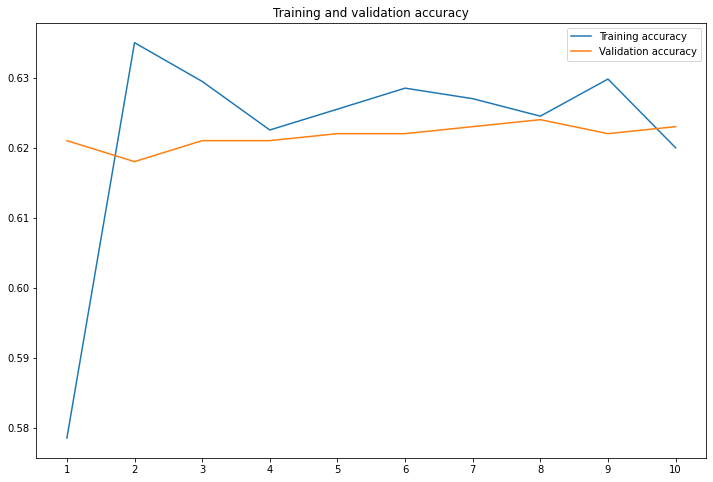

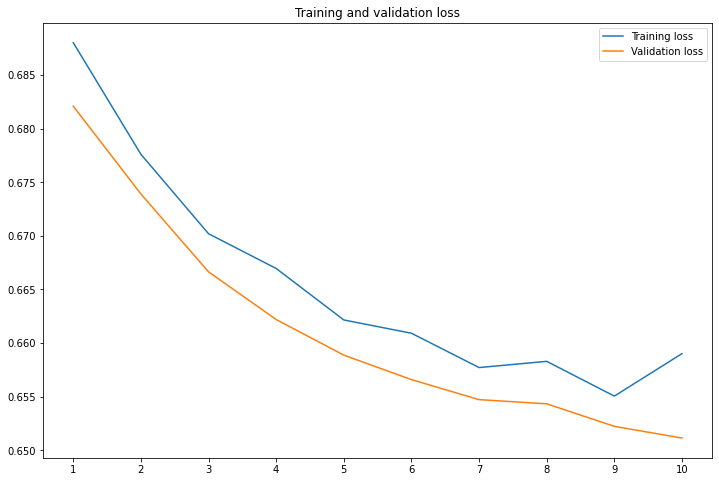

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()

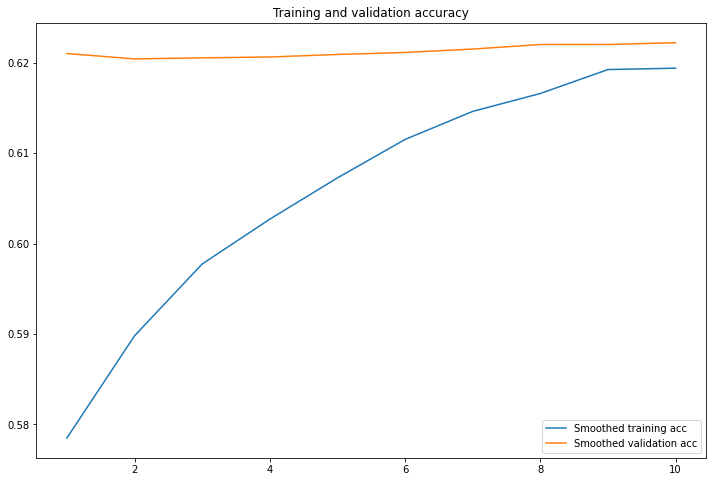

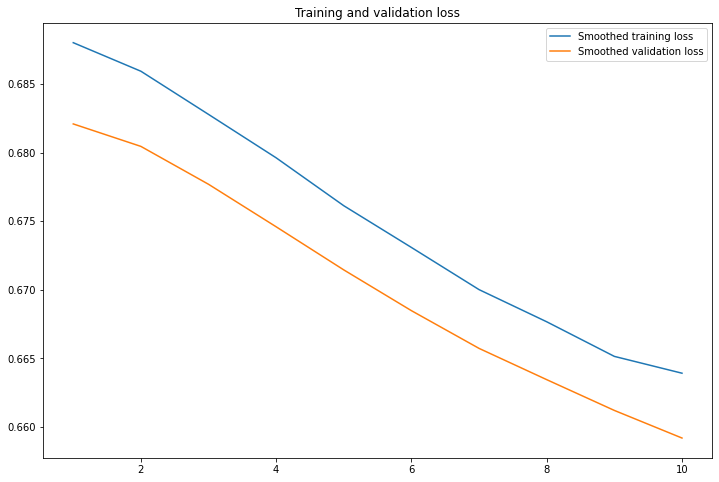

In [24]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.figure(figsize=(12,8))
plt.plot(epochs, smooth_curve(acc), label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, smooth_curve(loss), label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = train_datagen.flow_from_dataframe(
    test, # Referimos el df de train
    directory=data_dir, # El directorio donde se encuentran las imágenes
    x_col='image', # La columna con los path de los archivos
    y_col='Diabetes', # La variable con las labels
    target_size=(res_x, res_y),
    classes=None, # Las clases se obtienen a partir de y_col
    class_mode='binary', # Se trata de un problema multi-class, multi-label
    batch_size=20
   )

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Accuracy en test:', test_acc)
print('Loss en test:', test_loss)

Found 7452 validated image filenames belonging to 2 classes.
Accuracy en test: 0.640999972820282
Loss en test: 0.6409370303153992
